# Parsing Micron Sonar File from CSV format

In [11]:
# import external libraries
import csv
import datetime
import dateutil
import importlib
import pandas as pd
import plotly.express as px
import math
import numpy as np
import os
import seaborn as sns 
import scipy
import sys
from matplotlib import pyplot as plt 
from mpl_toolkits.axes_grid1 import make_axes_locatable

# add parent directory to the path for importing modules 
sys.path.insert(1, os.path.join(sys.path[0], '..'))
import micron_reader
import MicronEnsemble
import MicronTimeSeries

# use Seaborn settings for plotting 
sns.set()

---
## Plotting Ensemble

In [12]:
def plot_ensemble(ensemble, location, output_file=None):
    """Plots and Intensity in dB vs. Distance from transducer in meters.
    
    Also highlights the peak width selection, which is one of the primary
    features used for classifying different ice situations. 
    
    Args: 
        TODO
    """
    # constants 
    deg_in_quadrant = 90
    if ensemble.peak_width_bin == 0:  peak_alpha = 0
    else:                             peak_alpha = 0.3
    months = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr',  5:'May',  6:'Jun',
              7:'Jul', 8:'Aug', 9:'Sep',10:'Oct', 11:'Nov', 12:'Dec'}

    # generate plots
    sns.set(font_scale = 1.5)
    fig, ax = plt.subplots(figsize=(15,8))
    ax.plot(ensemble.intensity_data, linewidth=3, color='tab:blue')
    plt.axvspan(ensemble.peak_start_bin, ensemble.peak_end_bin, alpha=peak_alpha, color='tab:purple')

    # generate titles 
    fig.suptitle('Micron Sonar Ensemble, %s, %i %s %i' % 
                 (location, ensemble.day, months[ensemble.month], ensemble.year), 
                 fontsize=22, fontweight='bold')

    ax.set_title("Incidence: %3i$^\circ$   Bearing: %3i$^\circ$   Intensity: %2d dB   Peak Width: %.2f m" % 
                   (abs(ensemble.bearing - deg_in_quadrant), 
                    ensemble.bearing,
                    ensemble.max_intensity,
                    ensemble.peak_width), 
                 fontsize=18,
                 fontname='Courier New')

    # generate ticks and label axes 
    num_ticks = 11
    xticks = np.arange(0, ensemble.dbytes, ensemble.dbytes/(num_ticks-1))
    xticks = np.append(xticks, ensemble.dbytes)
    xtick_labels = ["%.1f" % (e*ensemble.bin_size) for e in xticks]
    ax.set_ylim(0,25) # TODO need to set y-limit better 
    ax.set_xticks(xticks)
    ax.set_xticklabels(xtick_labels)
    ax.set_xlabel('Distance from Transducer [m]')
    ax.set_ylabel('Intensity [dB]')
    ax.legend(['Intensity', 'Rolling Median','FWHM'], loc='best')

    # save the file if specified
    if output_file:
        plt.savefig("../figs/%s.png" % (output_file))
    plt.close()

---
## Plot Feature Space

In [13]:
def plot_features(time_series):
    """TODO
    """
    # plot
    fig = px.scatter_3d(
        time_series.df, 
        x = 'bearing', 
        y = 'peak_width', 
        z = 'max_intensity',
        title = "Micron Sonar Time Series in Feature Space",
        opacity=0.5,
        labels={
            "bearing" : "Bearing Angle [deg]",  
            "peak_width"        : "Peak Width [m]", 
            "max_intensity"     : "max_intensity [dB]"
        }
        
    )
    fig.show()


---
## Plot Polar Coordinates

In [29]:
def plot_polar(time_series, output_file=None):
    # get limits 
    left  = time_series.df['left_lim'][0]
    right = time_series.df['right_lim'][0]
    steps = time_series.df['steps'][0]
    swath = math.ceil(abs(right-left)/steps/2)
    bin_size = time_series.df['bin_size'][0]

    # filter out appropriate ranges 
    sonar_depth = 0.4 
    max_depth   = sonar_depth*1.5
    min_depth   = 0.3
    intensity_index   = time_series.intensity_index
    bin_labels  = time_series.df.columns[intensity_index:]
    sub_cols    = ['bearing_ref_world'] + list(bin_labels)
    df          = time_series.df[sub_cols][:swath]

    # melt data-frame into three columns: bearing, range, intensity 
    new_cols   = ['bearing_ref_world'] + [int(label[4:])*bin_size for label in bin_labels]
    df.columns = new_cols
    df         = pd.melt(df, id_vars=['bearing_ref_world'], var_name='range',value_name='intensity')

    # initialize plot format 
    sns.set(font_scale = 1.5)
    fig = plt.figure(figsize=(15,15))
    ax  = fig.add_subplot(111, projection='polar')
    ax.set_xticks(np.pi/180. * np.linspace(180,  -180, 24, endpoint=False))
    
    # plot the data 
    area = np.asarray(100*df['range'] + 20).astype(np.float64)
    img = ax.scatter(df['bearing_ref_world']*np.pi/180, df['range'], s=area, c=df['intensity'],cmap='viridis')
    ax.set_rmax(max_depth)
    ax.set_theta_zero_location('N')
    ax.set_theta_direction(-1)
    ax.set_thetalim(-np.pi, np.pi)
    # ax.set_thetamin(left)
    # ax.set_thetamax(right)
    ax.set_title('Micron Sonar Swath, Woods Hole MA', 
                 fontsize=22, fontweight='bold')
    
    # set colorbar ticks and labels 
    boundary    = 92
    fraction    = 0.025
    increment   = 5
    cbar_max    = math.ceil(np.max(df['intensity'])/increment)*increment
    cbar_ticks  = range(0,cbar_max,increment)
    cbar_labels = ["%2d dB" %(i) for i in cbar_ticks]
    cbar = fig.colorbar(img, fraction=fraction, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_labels)

    # # add orange divider at the boundary 
    # plt.axvspan((boundary-0.2)*np.pi/180, (boundary+0.2)*np.pi/180, color='tab:orange', alpha=0.6)

    # save the figure
    if output_file: 
        plt.savefig("../figs/%s.png" % (output_file))

---
## Reload Modules after Making Adjustments to the Code

In [24]:
importlib.reload(MicronEnsemble)
importlib.reload(MicronTimeSeries)
importlib.reload(micron_reader)

filepath = "/Users/zduguid/Dropbox (MIT)/MIT-WHOI/NSF Arctic NNA/Research Activities/2020-01-24_WHOI-Tank-Sonar-Testing/csv/Fri_24_Jan_13_34.CSV"
location = "Woods Hole MA"
date     = (2020, 1, 24)

constant_depth = 0.4

time_series = micron_reader.micron_reader(
    filepath, 
    location=location, 
    date=date,
    bearing_bias=0,
    constant_depth=constant_depth)

## Exploring Effect of Normalizing Intensity 

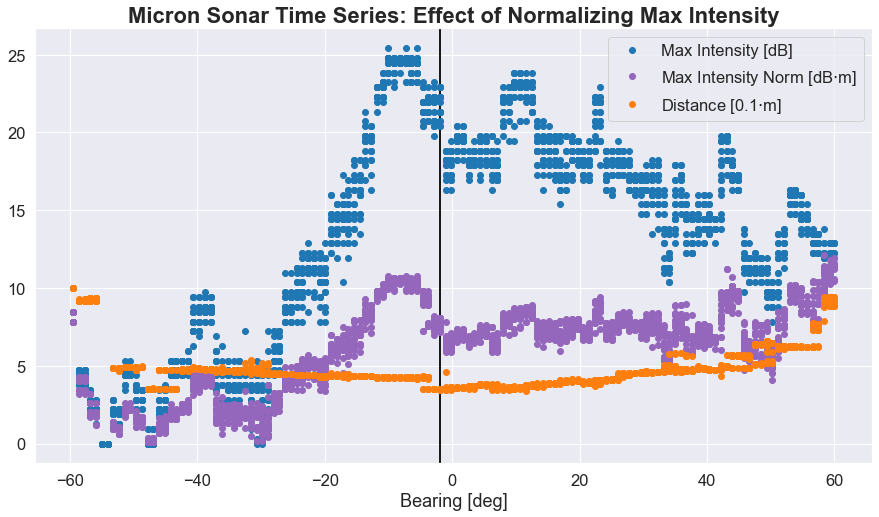

In [25]:
sns.set(font_scale = 1.5)
fig, ax = plt.subplots(figsize=(15,8))

# # normalizing between zero and 1 
# time_series.df['max_intensity']/np.max(time_series.df['max_intensity'])
# time_series.df['max_intensity_norm']/np.max(time_series.df['max_intensity_norm'])

angle_transition = -2

ax.plot(time_series.df['bearing'], 
        time_series.df['max_intensity'],
        'o', color='tab:blue')

ax.plot(time_series.df['bearing'], 
        time_series.df['max_intensity_norm'],
        'o', color='tab:purple')

ax.plot(time_series.df['bearing'], 
        time_series.df['peak_start']*10,
        'o', color='tab:orange')

ax.set_title('Micron Sonar Time Series: Effect of Normalizing Max Intensity', 
             fontsize=22, fontweight='bold')

plt.axvspan(angle_transition-0.1, angle_transition+0.1, color='k')

ax.set_xlabel('Bearing [deg]')
# ax.set_ylabel('Intensity [dB], Norm Intensity[dB$\cdot$m]')
ax.legend(['Max Intensity [dB]', 
           'Max Intensity Norm [dB$\cdot$m]', 
           'Distance [0.1$\cdot$m]'], loc='best')
plt.savefig("../figs/%s.png" % ('normalized-intensity6'))

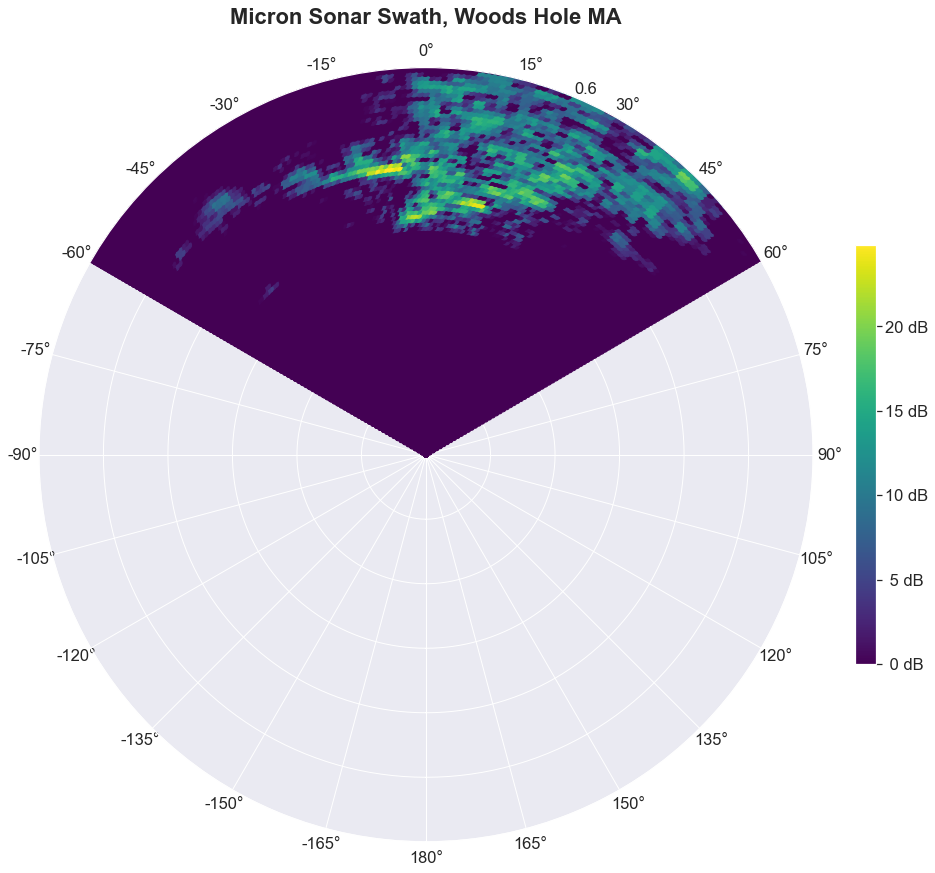

In [30]:
plot_polar(time_series)

---
## TEMP

In [ ]:

sns.set(font_scale = 1.5)
fig, ax = plt.subplots(3,figsize=(15,15))
ax[0].plot(time_series.df['bearing_ref_world']-90, time_series.df['peak_start']*np.cos((time_series.df['bearing_ref_world']-90)*np.pi/180), 'o')
ax[0].set_xlabel('Incidence Angle [deg]')
ax[0].set(xlabel='Incidence Angle [deg]')
ax[0].set_xlabel('Peak Width [m]')
ax[1].plot(time_series.df['incidence_angle'], time_series.df['max_intensity']*time_series.df['max_intensity_bin'],'o')
ax[0].set_xlabel('Incidence Angle [deg]')
ax[0].set_xlabel('Max Intensity [db]')
ax[2].plot(time_series.df['max_intensity']/time_series.df['max_intensity_bin'], time_series.df['peak_width'])
ax[0].set_xlabel('Max Intensity [db]')
ax[0].set_xlabel('Peak Width [m]')
plt.savefig("../figs/%s.png" % ('tmp2'))

In [ ]:
"""
    # store current angle and rounded angle 
    angle_current         = data_array[data_lookup['Bearing']]
    angle_current_rounded = math.floor(angle_current/angle_increment)*angle_increment
    
    # TODO make this a sub-method
    # compute the change in angle since a plot has been generated 
    if (not angle_previous): 
        angle_delta = 0
    else:  
        # add change current angle difference to the running sum since last plot 
        if angle_current - angle_previous > 0:
            angle_delta += angle_current - angle_previous 
        # account for instance where 
        else: 
            angle_delta += angle_current + deg_in_circle - angle_previous 
    
    # update previous angle 
    angle_previous = angle_current 
    
    # generate plot for every 20 degrees, avoid replotting area already plotted
    if ((angle_current_rounded % angle_increment == 0) and 
        (angle_delta > angle_increment/2) and 
        (angle_current_rounded not in angles_plotted) and 
        (plot_on)):
"""
z = 5

## Playing with Bit-Encoding of Micron Data

In [ ]:
int("8923", 16)
int("16", 16)
bin(int("16", 16))
bin(8923)

bin(16971)[2:][::-1]
int('1101001001000010'[::-1],2)

# 8923 hex -> 0b   1000 1001 0010 0011
# 8923 int -> 0b   0010 0010 1101 1011'

# 8967 hex -> 0b   1000 1001 0110 0111
# 8967 int -> 0b   0010 0011 0000 0111'

# 144  hex -> 0b 1 0100 0100
# 144  int -> 0b   1001 0000
# 16   hex -> 0b   0001 0110

# print(header[14], row1[14]) # column 14 is the number of data points in the scanline 
# print(header[15], row1[15]) # column 15 is the first value of an array DBytes long